In [1]:
import glob
import os
import sys
from time import time
import numpy as np
import pandas as pd
import torch
import torch_geometric as tg
import torch.nn.functional as F
import altair as alt
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sys.path.append('C:/Users/ewhalen/OneDrive - Massachusetts Institute of Technology/research/toolbox/caeSurrogateUtility/')
import caeUtility as cu

sys.path.append('./visualization')
from trussViz2D import plotTruss

sys.path.append('./readers')
from conmechToGraph import loadConmechGraph

## 1. Load simulation data

In [2]:
# check for data files
dataDir = 'C:/Users/ewhalen/Dropbox (MIT)/physics-informed networks (PINN)/01 Data generation/YJ/2D_Truss_v1.1/Data/10000_Samples'
resultFiles = glob.glob(os.path.join(dataDir, 'stiffness_results/*'))
runIds = [int(s.split('-')[-1].split('_')[0]) for s in resultFiles]

# load each graph
allGraphs = []
print(f'loading {len(resultFiles)} structures ', end='')
i = 0
for resultFile in resultFiles:
    # read json data
    if i%10 == 0: print('.', end='')
    graph = loadConmechGraph(resultFile)
    allGraphs.append(graph)
    i += 1

print(' done')

loading 10000 structures ...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

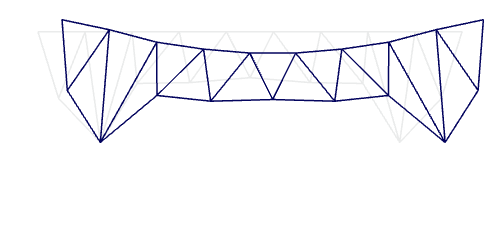

In [3]:
plotTruss(allGraphs[0], showPointLabels=False, showDeformed=True, defScale=50, showUndeformed=True, prediction=None)

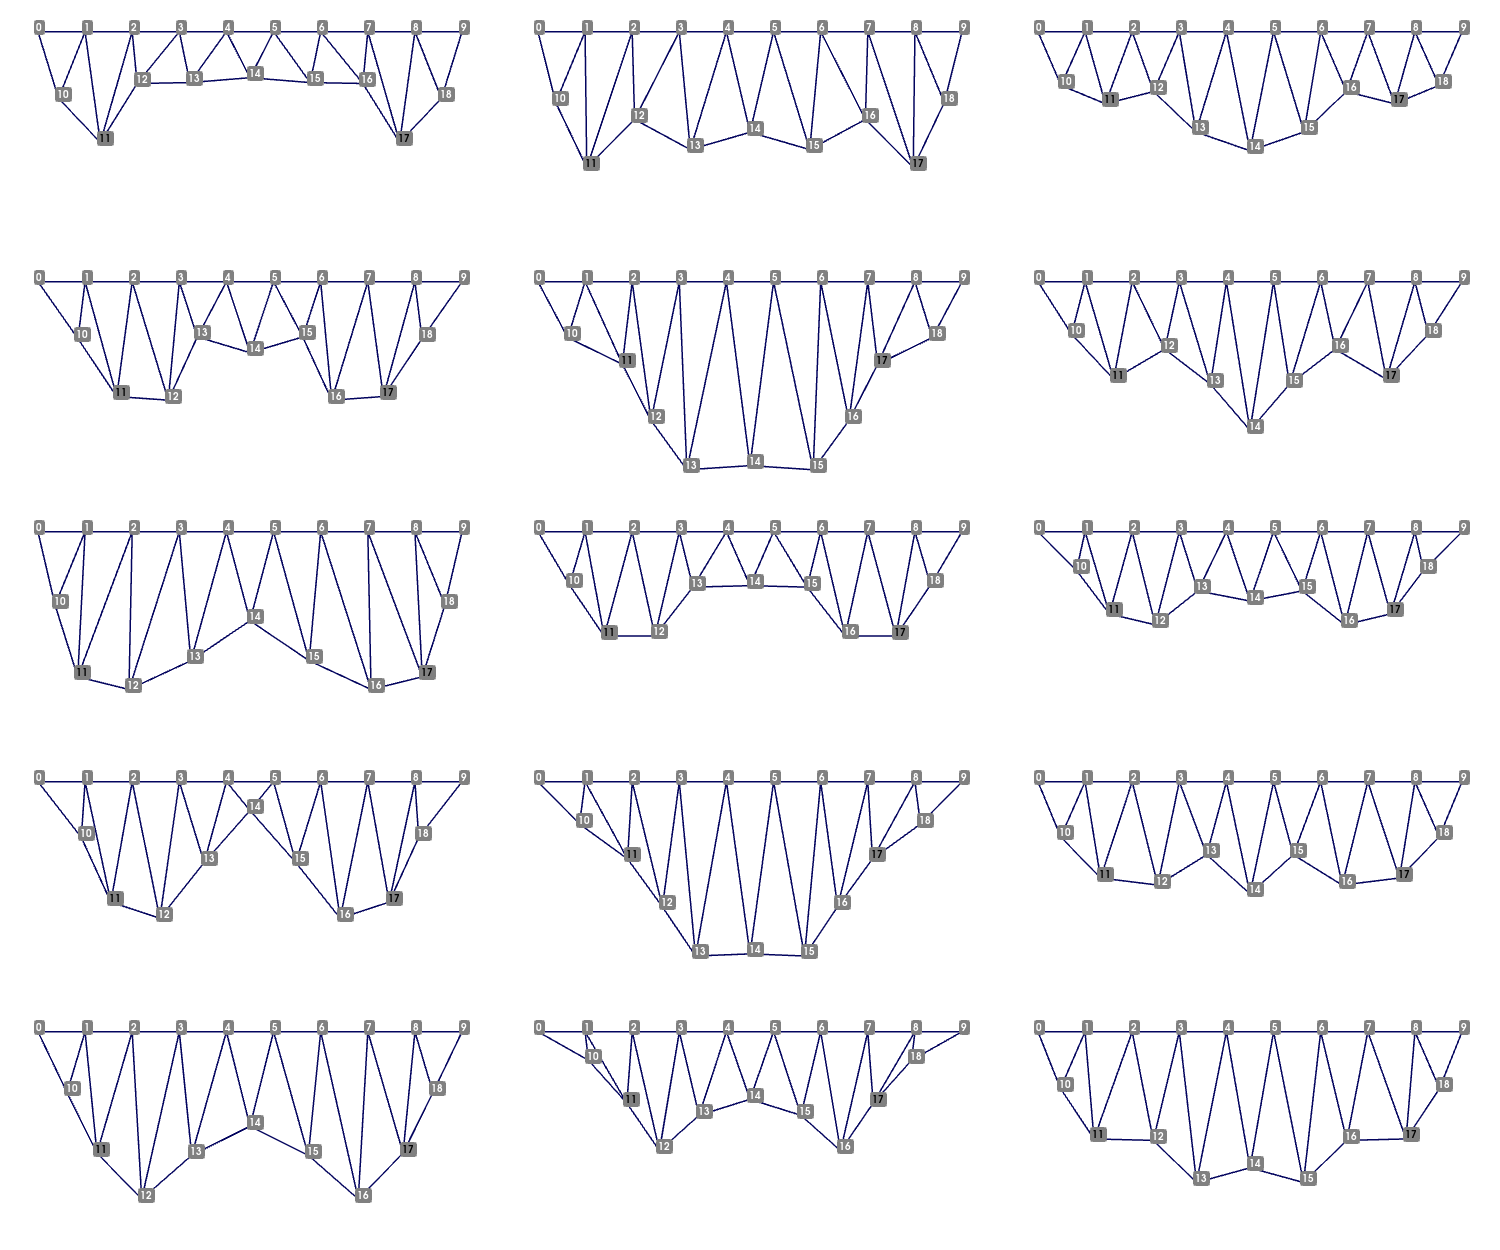

In [4]:
imgList = [plotTruss(g, screenshot=True) for g in allGraphs[:15]]
numCols = 3
numRows = int(np.ceil(len(imgList)/numCols))
h, w, _ = imgList[0].shape
tiledImg = np.empty((h*numRows, w*numCols, 4), dtype='uint8')
for row in range(numRows):
    for col in range(numCols):
        tiledImg[row*h:(row+1)*h,col*w:(col+1)*w] = imgList[row*numCols+col]
Image.fromarray(tiledImg)

## 2. Filter and transform

In [5]:
maxes = [max(np.abs(graph.y.numpy().flatten())) for graph in allGraphs]
source = pd.DataFrame(maxes, columns=['maxes'])
source.describe()

,maxes
count,10000.000000
mean,15.009532
std,1246.560325
min,0.007607
25%,0.029424
50%,0.048261
75%,0.100500
max,123269.273438


In [6]:
temp = []
for graph in allGraphs:
    if max(np.abs(graph.y.numpy().flatten())) < 1.0: temp.append(graph)
allGraphs = temp
maxes = [max(np.abs(graph.y.numpy().flatten())) for graph in allGraphs]
source = pd.DataFrame(maxes, columns=['maxes'])
source.describe()

,maxes
count,9790.000000
mean,0.084151
std,0.107889
min,0.007607
25%,0.029113
50%,0.047281
75%,0.094435
max,0.985807


In [7]:
# partition into train, validate and test
allIds = list(range(len(allGraphs)))
other, testIds = train_test_split(allIds, test_size=0.2, shuffle=True, random_state=1234) # 20% test
trainIds, valIds = train_test_split(other, test_size=0.15, shuffle=True, random_state=1234) # 15% val 15% test
trainGraphs = [allGraphs[i].clone() for i in trainIds]
valGraphs = [allGraphs[i].clone() for i in valIds]
testGraphs = [allGraphs[i].clone() for i in testIds]

# data transformations
ss = StandardScaler()

logTrans = lambda x: np.sign(x)*np.log(10.0*np.abs(x)+1.0)
invLogTrans = lambda y: np.sign(y)*(np.exp(np.abs(y))-1.0)/10.0

allResponses = np.empty((0,trainGraphs[0].y.numpy().size))
for graph in trainGraphs:
    allResponses = np.vstack([allResponses, graph.y.reshape(1,-1)])
ss.fit(allResponses)

for graph in trainGraphs+valGraphs+testGraphs:
    graph.y = torch.as_tensor(ss.transform(graph.y.reshape(1,-1)).reshape(-1,2), dtype=torch.float)
    graph.y = logTrans(graph.y)

## 3. Define model and train

In [8]:
## define network architecture
#############################################################
class FeaStNet(torch.nn.Module):
    def __init__(self):
        super(FeaStNet, self).__init__()
        self.norm0 = tg.nn.BatchNorm(4, momentum=0.3, affine=True, track_running_stats=True)
        self.lin0 = torch.nn.Linear(4, 16)
        self.conv0 = tg.nn.FeaStConv(16, 32, heads=8) # The (translation-invariant) FeaStNet convolution
        self.normc0 = tg.nn.BatchNorm(32, momentum=0.3, affine=True, track_running_stats=True)
        self.conv1 = tg.nn.FeaStConv(32, 64, heads=8)
        self.normc1 = tg.nn.BatchNorm(64, momentum=0.3, affine=True, track_running_stats=True)
        self.conv2 = tg.nn.FeaStConv(64, 128, heads=8)
        self.normc2 = tg.nn.BatchNorm(128, momentum=0.3, affine=True, track_running_stats=True)
        self.conv3 = tg.nn.FeaStConv(128, 256, heads=8)
        self.normc3 = tg.nn.BatchNorm(256, momentum=0.3, affine=True, track_running_stats=True)
        self.conv4 = tg.nn.FeaStConv(256, 128, heads=8)
        self.normc4 = tg.nn.BatchNorm(128, momentum=0.3, affine=True, track_running_stats=True)
        self.conv5 = tg.nn.FeaStConv(128, 128, heads=8)
        self.normc5 = tg.nn.BatchNorm(128, momentum=0.3, affine=True, track_running_stats=True)
        self.lin1 = torch.nn.Linear(128, 64)
        self.lin2 = torch.nn.Linear(64, 2)

    def forward(self, data):
        data.x = torch.cat([data.pos, data.x.float()], 1)
        data.x = self.norm0(data.x)
        data.x = self.lin0(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv0(data.x, data.edge_index)
        data.x = self.normc0(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv1(data.x, data.edge_index)
        data.x = self.normc1(data.x)
        data.x = F.relu(data.x)        
        data.x = self.conv2(data.x, data.edge_index)
        data.x = self.normc2(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv3(data.x, data.edge_index)
        data.x = self.normc3(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv4(data.x, data.edge_index)
        data.x = self.normc4(data.x)
        data.x = F.relu(data.x)
        data.x = self.conv5(data.x, data.edge_index)
        data.x = self.normc5(data.x)
        data.x = F.relu(data.x)
        data.x = self.lin1(data.x)
        data.x = F.relu(data.x)
        data.x = self.lin2(data.x)
        return data.x
    
# configure training
def train(model, loader, valData, device, epochs=10, saveDir=None):
    modelFile = None
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=10e-4)
    trainHist, valHist = [], []
    model.to(device)
    
    if saveDir:
        if not os.path.exists(saveDir): os.mkdir(saveDir)
    for epoch in range(epochs):

        ### train ###
        model.train()
        t = time()
        batchHist = []
        for batch in loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            batchHist.append(loss.item())

        trainHist.append(np.mean(batchHist))
        
        ### validate ###
        batchHist = []
        valLoader = tg.data.DataLoader(valData, batch_size=1, shuffle=False)
        model.eval()
        with torch.no_grad():
            for batch in valLoader:
                batch.to(device)
                out = model(batch)
                loss = F.mse_loss(out, batch.y)
                batchHist.append(loss.item())
        valHist.append(np.mean(batchHist))

#         if epoch%(epochs//10)==(epochs//10)-1 and epoch>0:
#             print(f'epoch: {epoch}   trainLoss: {trainHist[-1]:.4e}   time: {(time()-t):.2e}')
        print(f'epoch: {epoch}   trainLoss: {trainHist[-1]:.4e}   time: {(time()-t):.2e}')
                     
        if saveDir:
            with open(os.path.join(saveDir, 'trainlog.csv'), 'a') as fp: 
                fp.write(f'{epoch},{trainHist[-1]},{valHist[-1]},{(time()-t)}\n')
                
            if (np.argmin(valHist) == len(valHist)-1):
                modelFile = os.path.join(saveDir, f'checkpoint_{epoch}')
                torch.save(model.state_dict(), modelFile) # save best model    

    return trainHist, valHist, modelFile

def test(model, inputs, outputs, baselineRef, device, ss=None, log=None, level='set'):
    model.to(device)
    preds = []
    model.eval()
    testLoader = tg.data.DataLoader(inputs, batch_size=1, shuffle=False)
    with torch.no_grad():
        for batch in testLoader:
            batch.to(device)
            out = model(batch)
            p = out.cpu().numpy()
            if log: p = invLogTrans(p)
            if ss: p = ss.inverse_transform(p.reshape(1,-1)).reshape(-1,2)
            preds.append(p)
        
    return cu.computeFieldLossMetrics([g.y.numpy() for g in outputs], 
                                      preds, 
                                      baselineRef=[b.y.numpy() for b in baselineRef], level=level)

def predict(model, inputs, device, ss=None, log=None):
    model.to(device)
    model.eval()
    testLoader = tg.data.DataLoader(inputs, batch_size=1, shuffle=False)
    with torch.no_grad():
        for batch in testLoader:
            batch.to(device)
            out = model(batch)
            p = out.cpu().numpy()
            if log: p = invLogTrans(p)
            if ss: p = ss.inverse_transform(p.reshape(1,-1)).reshape(-1,2)
            return p

def plotHistory(trainHist, valHist):
    histDf = pd.DataFrame({'train': trainHist, 'val': valHist})
    return alt.Chart(histDf.reset_index()).transform_fold(
            ['train', 'val'],
            as_=['metric', 'value']
        ).mark_line().encode(
            alt.X('index:Q'),
            alt.Y('value:Q', axis=alt.Axis(title='loss')),
            color=alt.Color('metric:N'),
            tooltip=['epoch:Q', 'value:Q']
        ).properties(width=400, height=200)

In [9]:
# train FeaStNet
feastnet = FeaStNet()
# device = torch.device('cuda')
device = torch.device('cpu')
loader = tg.data.DataLoader(trainGraphs[:1000], batch_size=16, shuffle=True)
trainHist, valHist, modelFile = train(feastnet, loader, valGraphs[:5], device, epochs = 100, saveDir='1ktrainValTest08-local')

# load best model
bestModel = FeaStNet()
bestModel.load_state_dict(torch.load(modelFile))

# test
print(test(bestModel, 
           trainGraphs, 
           [allGraphs[i] for i in trainIds],
           [allGraphs[i] for i in trainIds], 
           device, ss=ss, log=True))
print(test(bestModel, 
           testGraphs, 
           [allGraphs[i] for i in testIds],
           [allGraphs[i] for i in trainIds], 
           device, ss=ss, log=True))
plotHistory(trainHist, valHist)

epoch: 0   trainLoss: 2.1086e+00   time: 5.18e+00
epoch: 1   trainLoss: 1.2376e+00   time: 5.28e+00
epoch: 2   trainLoss: 8.6852e-01   time: 5.65e+00
epoch: 3   trainLoss: 7.4528e-01   time: 6.18e+00
epoch: 4   trainLoss: 6.8273e-01   time: 5.88e+00
epoch: 5   trainLoss: 6.1716e-01   time: 6.24e+00
epoch: 6   trainLoss: 5.2387e-01   time: 5.92e+00
epoch: 7   trainLoss: 4.9865e-01   time: 5.80e+00
epoch: 8   trainLoss: 4.7399e-01   time: 5.64e+00
epoch: 9   trainLoss: 4.7077e-01   time: 5.78e+00
epoch: 10   trainLoss: 4.3008e-01   time: 6.33e+00
epoch: 11   trainLoss: 4.4438e-01   time: 5.98e+00
epoch: 12   trainLoss: 4.2304e-01   time: 5.89e+00
epoch: 13   trainLoss: 4.1272e-01   time: 5.73e+00
epoch: 14   trainLoss: 3.4976e-01   time: 5.73e+00
epoch: 15   trainLoss: 3.5901e-01   time: 5.64e+00
epoch: 16   trainLoss: 3.4660e-01   time: 6.01e+00
epoch: 17   trainLoss: 3.4416e-01   time: 6.09e+00
epoch: 18   trainLoss: 3.3205e-01   time: 6.12e+00
epoch: 19   trainLoss: 3.5319e-01   time:

alt.Chart(...)

## 4. Visualize some predictions

In [14]:
testFieldMetrics = test(bestModel, 
                       testGraphs, 
                       [allGraphs[i] for i in testIds],
                       [allGraphs[i] for i in trainIds], 
                       device, ss=ss, log=True, level='field')

In [15]:
df = pd.DataFrame(testFieldMetrics)
df['rank'] = df['mse'].rank()
df = df.sort_values('rank')
df['percentile'] = df['mse'].rank(pct=True)
# df[df.percentile>.9]
df

,mse,mae,mre,maxAE,mae/peak,maxAE/peak,relEAtPeak,rank,percentile
1524,0.000003,0.001291,0.087595,0.003745,0.051267,0.148714,0.029563,1.0,0.000511
1876,0.000003,0.001301,0.063221,0.005712,0.035001,0.153637,0.009572,2.0,0.001021
238,0.000004,0.001626,0.104964,0.004389,0.056837,0.153393,0.073614,3.0,0.001532
1167,0.000004,0.001532,0.067554,0.005645,0.039926,0.147088,0.037141,4.0,0.002043
1207,0.000004,0.001443,0.095240,0.006271,0.052002,0.225907,0.023229,5.0,0.002554
...,...,...,...,...,...,...,...,...,...
1871,0.064146,0.218259,0.676555,0.447464,0.279197,0.572396,0.548966,1954.0,0.997957
132,0.076661,0.233757,0.708184,0.681047,0.261174,0.760926,0.663780,1955.0,0.998468
1129,0.091543,0.266464,0.755029,0.672720,0.322046,0.813044,0.673639,1956.0,0.998979
729,0.112463,0.196285,0.436161,1.255969,0.237857,1.521978,0.993081,1957.0,0.999489


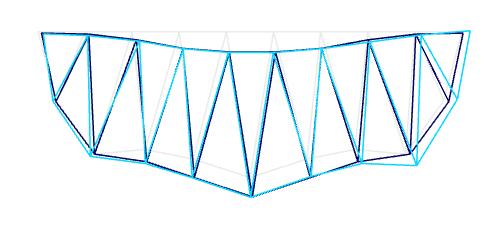

In [22]:
i=6
graph = allGraphs[testIds[i]]
pred = predict(bestModel, [graph], device, ss=ss, log=True)
plotTruss(graph, showPointLabels=False, showDeformed=True, defScale=100, showUndeformed=True, prediction=pred)

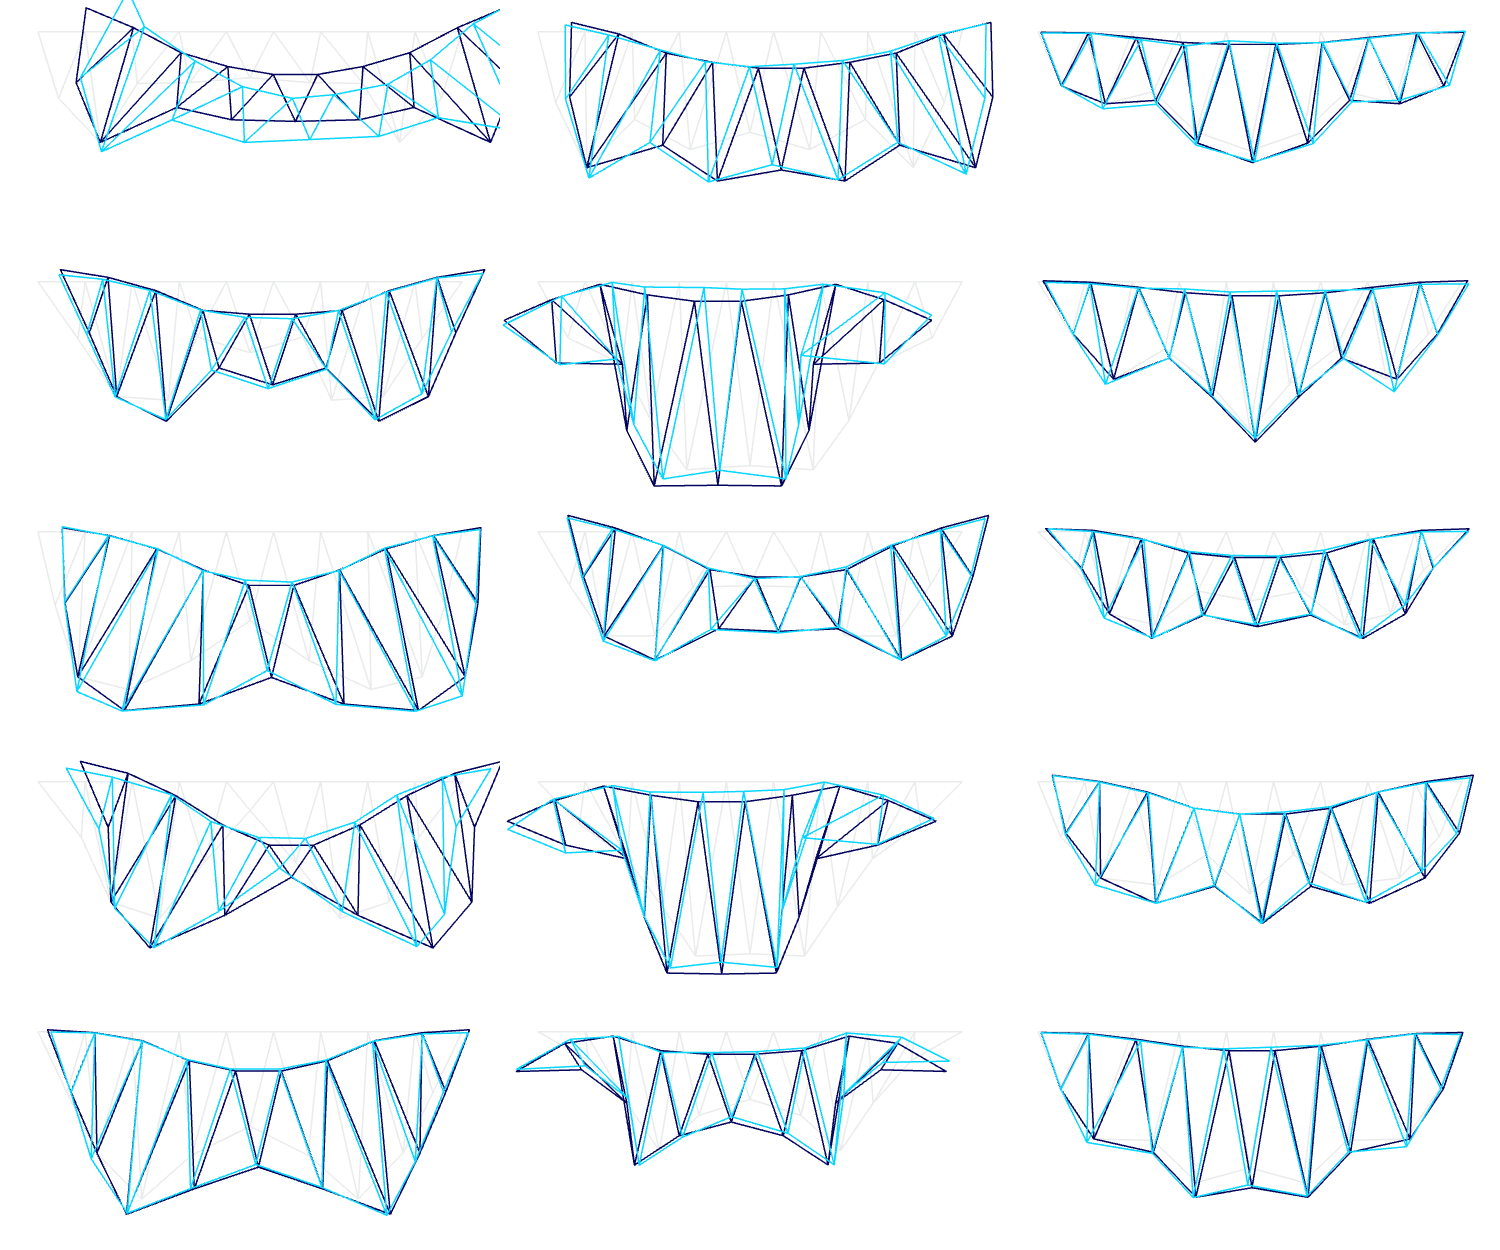

In [23]:
predList = [predict(bestModel, [g], device, ss=ss, log=True) for g in allGraphs[:15]]
imgList = [plotTruss(g, screenshot=True, showPointLabels=False, showDeformed=True, defScale=100, showUndeformed=True, prediction=p) for g,p in zip(allGraphs[:15], predList)]
numCols = 3
numRows = int(np.ceil(len(imgList)/numCols))
h, w, _ = imgList[0].shape
tiledImg = np.empty((h*numRows, w*numCols, 4), dtype='uint8')
for row in range(numRows):
    for col in range(numCols):
        tiledImg[row*h:(row+1)*h,col*w:(col+1)*w] = imgList[row*numCols+col]
Image.fromarray(tiledImg)